In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime

import readfunctions as rf
import lmasources as ls
from coordinateSystems import GeographicSystem, MapProjection

In [3]:
geo   = GeographicSystem()

## Read in radar analysis

#### And pulling out the radar grid points for plotting later

In [4]:
filename = '/localdata/wind_analysis/sr12noxp_tdvar_2348_var.out'

dataf       = rf.outfile(filename)
r,u,v,w     = dataf.read_data() # These are in z,y,x
lon,lat,alt = dataf.latlon(geo)

rx,ry,rz = dataf.data_grid()
rx       = rx.reshape(np.shape(w))
ry       = ry.reshape(np.shape(w))
rz       = rz.reshape(np.shape(w))

## Corresponding LMA from .dat file

Analysis is at the time listed, every 3 min, so pulling source points for the following 3 minutes

In [5]:
lma_directory = '/home/vanna.chmielewski/analyzedlightning/notgz/'
lma_file = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,dataf.time[:3])
lmad = ls.lmafile(lma_file).readfile()

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    lma_file2 = '{0}LYLOUT_{1}0.exported.dat'.format(lma_directory,sfi.strftime('%H%M')[:3])
    lmad2 = ls.lmafile(lma_file2).readfile()
    lmad = pd.concat((lmad,lmad2))

Setting limits for selection from the following 3 min and setting station minimum and chi squared maximum

In [6]:
tstart = int(dataf.time[:2])*3600 + int(dataf.time[2:])*60
tend   = tstart + 3*60
mxchi  = 1.0
mnnum  = 7.0

sources = lmad[(lmad['time'] >= tstart)  & (lmad['time'] < tend) & 
               (lmad['chi']  <= mxchi)   & (lmad['num'] >= mnnum)]
psource = sources[sources['charge'] ==  3]
nsource = sources[sources['charge'] == -3]

### Mapping and gridding corresponding to radar grid (in x,y,z)

Plot check for sanity

In [7]:
exs,eys,ezs = geo.toECEF(np.array(sources['lon']),
                         np.array(sources['lat']),
                         np.array(sources['alt']))
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
nxs,nys,nzs = projl.fromECEF(exs,eys,ezs)

In [8]:
binz = np.arange(dataf.iz,dataf.nz*dataf.dz+dataf.iz+dataf.dz,dataf.dz)-dataf.dz/2.
biny = np.arange(dataf.iy,dataf.ny*dataf.dy+dataf.iy+dataf.dy,dataf.dy)-dataf.dy/2.
binx = np.arange(dataf.ix,dataf.nx*dataf.dx+dataf.ix+dataf.dx,dataf.dx)-dataf.dx/2.

negs = sources['charge'] == -3
poss = sources['charge'] ==  3
unas = sources['charge'] ==  0
abins = (binx,biny,binz)

all_counts = np.histogramdd(np.array([nxs,nys,nzs]).T,bins=abins)[0]
p_counts   = np.histogramdd(np.array([nxs[poss],nys[poss],nzs[poss]]).T,bins=abins)[0]
n_counts   = np.histogramdd(np.array([nxs[negs],nys[negs],nzs[negs]]).T,bins=abins)[0]

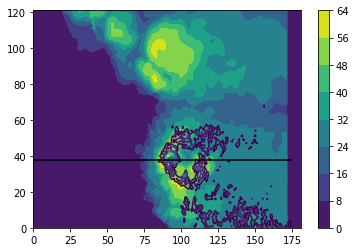

In [9]:
gridcell = 38

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[20])
plt.hlines(gridcell,0,175)
plt.colorbar()

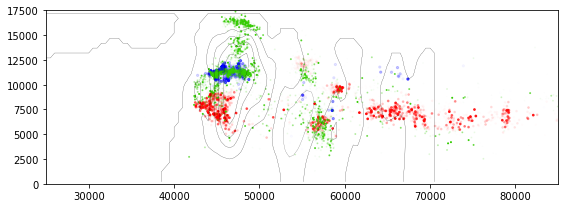

In [10]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-gridcell*dataf.dx)
alpha = np.exp(-dist/400.)

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

## Read in flash-sorted grid files

In [11]:
flash_grid_dir = '/localdata/KingfisherAnalysis/flashsort/grid_files/2012/May/29/'

grid_var = {'flash_extent' : 'flash_extent',
            'flash_init' : 'flash_initiation',
            'flashsize_std' : 'flashsize_std',
            'footprint' : 'flash_footprint',
            'source' : 'lma_source',
            'specific_energy' : 'specific_energy',
            'total_energy' : 'total_energy',
           }

In [12]:
flashgrid = xr.Dataset()
for key in grid_var:
    filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,dataf.time[:3],key)
    flashgrid = xr.auto_combine((flashgrid,xr.open_dataset(filename)))

#
## This takes WAY too much memory. MUST be a better way
#

# if int(dataf.time[3]) > 7:
#     flashgrid2 = xr.Dataset()
#     sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
#     for key in grid_var:
#         filename = '{0}OKLMA_20120529_{1}000_600_10src_0.0055deg-dx_{2}_3d.nc'.format(flash_grid_dir,sfi.strftime('%H%M')[:3],key)
#         flashgrid2 = xr.auto_combine((flashgrid2,xr.open_dataset(filename)))
# #     flashgrid = xr.concat((flashgrid,flashgrid2),'ntimes',data_vars='minimal')

In [13]:
glo,gla,gal = np.meshgrid(np.array(flashgrid['longitude']),
                          np.array(flashgrid['latitude']),
                          np.array(flashgrid['altitude']))

gexs,geys,gezs = geo.toECEF(glo,gla,gal)
projl = MapProjection(projection='laea', lat_0=dataf.lat, lon_0=dataf.lon, alt_0=dataf.alt)
gnxs,gnys,gnzs = projl.fromECEF(gexs,geys,gezs)

### DLA analysis FORTRAN-array output text files

Same grid as radar analysis, trajectory files are on $\Delta$t by subsetted z,y,x

In [14]:
DLAvariables = ['obqrat','obqclw','obqxlw','obthet','obthetv',
                'obqrlw','obqslw','obqglw']

i = 0
DLA = np.zeros((8,35,122,182))
for vari in DLAvariables:
    testfile = '/localdata/DLA/output/{0}_gto_{1}.txt'.format(vari,dataf.time)
    test = pd.read_csv(testfile,header=None,delim_whitespace=True,na_values=-1000.0)
    DLA[i] = np.array(test).flatten()[:-57].reshape((35,122,182))
    i = i+1

# Matchin up different grids (y-cross section)

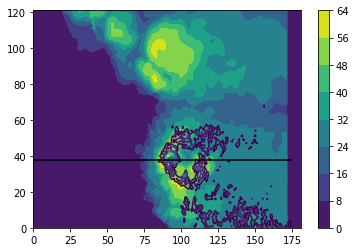

In [15]:
mfrom0 = gridcell*dataf.dx

plt.contour(np.sum(all_counts,axis=2).T,20)
plt.contourf(r[20])
plt.hlines(mfrom0/dataf.dx,0,175)
plt.colorbar()

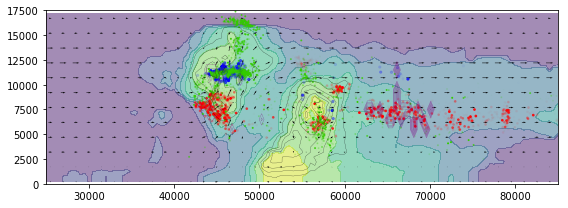

In [23]:
plt.figure(figsize=(8,3))

dist = np.abs(nys-mfrom0)
alpha = np.exp(-dist/400.)

rgrid = int(mfrom0/dataf.dx)
lgrid = np.argmin(np.abs(gnys[:,0,0] - mfrom0))

plt.contourf(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],cmap='viridis',alpha=0.5)
# plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],r[:,rgrid,:],colors='y',linewidths=0.2)
plt.contour(rx[:,rgrid,:],rz[:,rgrid,:],DLA[7,:,rgrid,:],colors='k',linewidths=0.2)

step=3
plt.quiver(rx[::step,rgrid,::step],rz[::step,rgrid,::step],
            u[::step,rgrid,::step], w[::step,rgrid,::step],
#            headwidth=1,headlength=1,
           scale=2500,
           width=0.001,
           pivot='middle',
          )

plt.contour(gnxs[lgrid,:,:],gnzs[lgrid,:,:],flashgrid['flash_footprint'][8,:,lgrid,:],colors='purple',linewidths=0.2)
c = np.asarray([(0,0,1,a) for a in alpha])[negs]
plt.scatter(nxs[negs],nzs[negs],color=c,edgecolors=c,s=5)
c = np.asarray([(1,0,0,a) for a in alpha])[poss]
plt.scatter(nxs[poss],nzs[poss],color=c,edgecolors=c,s=3)
c = np.asarray([(0.2,0.8,0,a) for a in alpha])[unas]
plt.scatter(nxs[unas],nzs[unas],color=c,edgecolors=c,s=1)

plt.xlim(50*dataf.dx,170*dataf.dx)
plt.ylim(0,17500)
plt.tight_layout()

### Read in h5 flash files

Just in case these become more important later

In [152]:
filename = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(dataf.time[:3])

sources = pd.read_hdf(filename,'events/LMA_120529_{0}000_600'.format(dataf.time[:3]))
flashes = pd.read_hdf(filename,'flashes/LMA_120529_{0}000_600'.format(dataf.time[:3]))

if int(dataf.time[3]) > 7:
    sfi = datetime.datetime(2012,5,29,int(dataf.time[:2]),int(dataf.time[2:])) + datetime.timedelta(minutes=10)
    file2 = '/localdata/KingfisherAnalysis/flashsort/h5_files/2012/May/29/LYLOUT_120529_{0}000_0600.exported.dat.flash.h5'.format(sfi.strftime('%H%M')[:3])
    sources2 = pd.read_hdf(file2,'events/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    flashes2 = pd.read_hdf(file2,'flashes/LMA_120529_{0}000_600'.format(sfi.strftime('%H%M')[:3]))
    sources = pd.concat((sources,sources2))
    flashes = pd.concat((flashes,flashes2))

### Fiddling with flash grid files

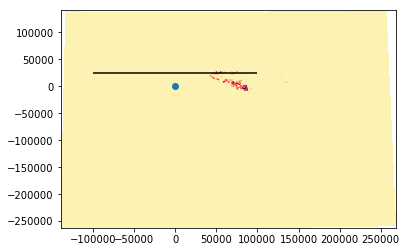

In [40]:
lev = 8
hlev = 571

# plt.contourf(glo[:,:,0],gla[:,:,0],flashgrid['lma_source'][8:10].sum(axis=(0,3)).T,30,cmap='magma_r')
# plt.contourf(flashgrid['longitude'],flashgrid['latitude'],flashgrid['lma_source'][8].sum(axis=2).T,20,cmap='magma_r')
plt.contourf(gnxs[:,:,lev],gnys[:,:,lev],flashgrid['lma_source'][8,:,:,lev].T,20,cmap='magma_r')
plt.hlines(gnys[hlev,0,0],-100000,100000)
plt.scatter(0,0)

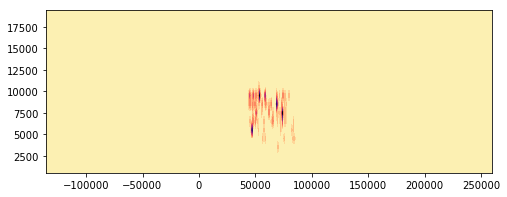

In [64]:
plt.figure(figsize=(8,3))
plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(gnxs[hlev,:,:],gnzs[hlev,:,:],flashgrid['lma_source'][8,:,hlev,:],20,cmap='magma_r')
# plt.contourf(flashgrid['lma_source'][8,:,hlev,:].T,20,cmap='magma_r')
# plt.xlim(50*dataf.dx,170*dataf.dx)
# plt.ylim(0,17500)

#### Other testing

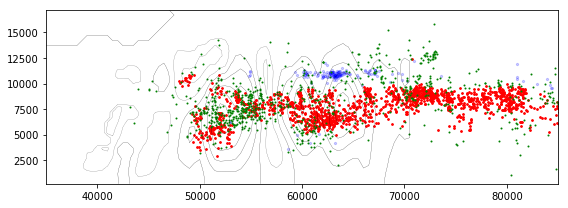

In [118]:
plt.figure(figsize=(8,3))

# gridcell = 60
depth    =  5

plt.contour(rx[:,gridcell,:],rz[:,gridcell,:],w[:,gridcell,:],colors='k',linewidths=0.2)

c = 'b'
selection = (negs) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=5,alpha=0.2)
c = 'r'
selection = (poss) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=3)
c = 'g'
selection = (unas) & (np.abs(nys-gridcell*dataf.dx) <1000.)
plt.scatter(nxs[selection],nzs[selection],color=c,edgecolors=c,s=1)

plt.xlim(70*dataf.dx,170*dataf.dx)
plt.tight_layout()

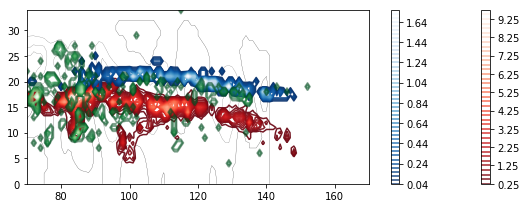

In [14]:
plt.figure(figsize=(8,3))

plt.contour(w[:,gridcell,:],colors='k',linewidths=0.2)

# plt.contour(np.ma.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T,colors='k',linewidths=0.1)
plt.contour(np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,40,cmap='Reds_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T/depth,50,cmap='Blues_r',alpha=0.9)
plt.colorbar()
plt.contour(np.sum(all_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(p_counts[:,gridcell-depth:gridcell+depth],axis=1).T-
            np.sum(n_counts[:,gridcell-depth:gridcell+depth],axis=1).T,30,cmap='Greens_r', alpha=0.5)

plt.xlim(70,170)
plt.tight_layout()

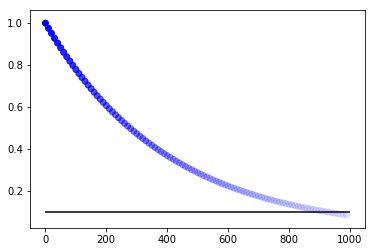

In [119]:
dist = np.arange(0.1,1000,10)
# alpha = 100./(dist)
alpha = np.exp(-dist/400.)
# alpha[alpha>1] = 1

c = np.asarray([(0,0,1,a) for a in alpha])
plt.scatter(dist,alpha,color=c,edgecolors=c)
plt.hlines(0.1,0,1000)